<a href="https://colab.research.google.com/github/educarrascov/DISC_TESIS/blob/main/20250822_PWL_MNLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Demostración visual de Piecewise Linearization (PWL) sobre f(y) = exp(y)
#### - Mostramos la función original (antes) y su aproximación PWL (después).
#### - Usamos cuerdas (chords) entre puntos de quiebre para una SOBRE-ESTIMACIÓN convexa (útil en MINIMIZACIÓN convexa).
#### - Variamos K (número de puntos de quiebre) y graficamos:
#####     (1) f(y) y PWL para varios K
#####     (2) Error absoluto |PWL - f| vs y para cada K

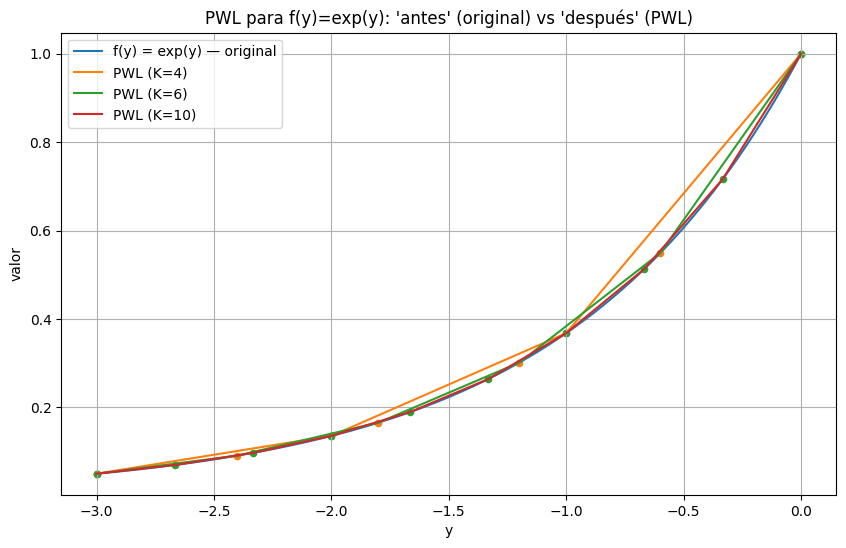

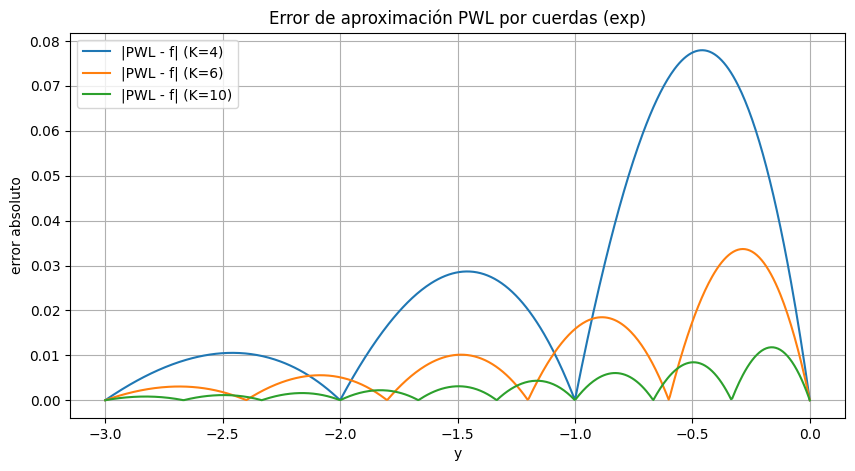

Resumen de error máximo en [L,U] por cada K:
  K= 4  ->  max |PWL - f| = 7.794007e-02
  K= 6  ->  max |PWL - f| = 3.367120e-02
  K=10  ->  max |PWL - f| = 1.179167e-02

Formulación PWL (convex combination) para t ≈ f(y) con cuerdas (sobre-estimación convexa):

Dado un conjunto de quiebres {y_1 < y_2 < ... < y_K} y los puntos en el gráfico (y_k, f(y_k)),
introducimos variables λ_k ≥ 0 con restricción especial de orden (SOS2) para asegurar adyacencia.

Restricciones:
  sum_{k=1..K} λ_k = 1
  y = sum_{k=1..K} y_k * λ_k
  t ≥ sum_{k=1..K} f(y_k) * λ_k        (cuerda → sobre-estimador de f en [y_1, y_K])
  λ ∈ SOS2                              (a lo sumo 2 λ_k adyacentes pueden ser >0)

Minimizando t (si f es convexa), esto da un upper bound del original.

Notas:
- Para una sub-estimación (lower bound), usa planos tangentes: t ≤ f(ŷ) + f'(ŷ)*(y - ŷ).
- Un esquema OA alterna ambos para cerrar gap (exacto en convexos).



In [6]:
import numpy as np
import matplotlib.pyplot as plt

# ---------- Función base (convexa) ----------
def f(y):
    return np.exp(y)  # en tu WTA aparece exp( suma a_ij x_ij ), aquí fijamos el unidimensional

# Intervalo relevante: en WTA los a_ij = ln(1-p_ij) <= 0 => y suele ser <= 0
L, U = -3.0, 0.0

# ---------- Utilidades PWL (cuerdas) ----------
def pwl_chord(y_grid, y_knots, f):
    """
    Aproxima f en y_grid con cuerdas entre puntos de quiebre y_knots (ordenados).
    Devuelve valores PWL(y) y también los segmentos (para graficar si se quiere).
    """
    y_knots = np.asarray(y_knots, dtype=float)
    f_knots = f(y_knots)
    # Para cada y del grid, ubicar el intervalo [k, k+1] y hacer interp lineal
    idx = np.searchsorted(y_knots, y_grid, side="right") - 1
    idx = np.clip(idx, 0, len(y_knots)-2)
    y0 = y_knots[idx]
    y1 = y_knots[idx+1]
    f0 = f_knots[idx]
    f1 = f_knots[idx+1]
    # Interpolación lineal
    t = (y_grid - y0) / (y1 - y0 + 1e-15)
    pwl = f0 + t * (f1 - f0)
    return pwl, (y_knots, f_knots)

# ---------- Experimento con varios K ----------
Ks = [4, 6, 10]               # número de puntos de quiebre
y_grid = np.linspace(L, U, 600)

# Figura 1: f(y) vs PWL para varios K
plt.figure(figsize=(10,6))
plt.plot(y_grid, f(y_grid), label="f(y) = exp(y) — original")
for K in Ks:
    y_knots = np.linspace(L, U, K)
    pwl_vals, (yk, fk) = pwl_chord(y_grid, y_knots, f)
    plt.plot(y_grid, pwl_vals, label=f"PWL (K={K})")
    # marcar quiebres
    plt.scatter(yk, fk, s=20)
plt.xlabel("y")
plt.ylabel("valor")
plt.title("PWL para f(y)=exp(y): 'antes' (original) vs 'después' (PWL)")
plt.legend()
plt.grid()
plt.show()

# Figura 2: Error absoluto
plt.figure(figsize=(10,5))
for K in Ks:
    y_knots = np.linspace(L, U, K)
    pwl_vals, _ = pwl_chord(y_grid, y_knots, f)
    err = np.abs(pwl_vals - f(y_grid))
    plt.plot(y_grid, err, label=f"|PWL - f| (K={K})")
plt.xlabel("y")
plt.ylabel("error absoluto")
plt.title("Error de aproximación PWL por cuerdas (exp)")
plt.legend()
plt.grid()
plt.show()

# ---------- Resumen numérico ----------
def max_err_for_K(K):
    y_knots = np.linspace(L, U, K)
    pwl_vals, _ = pwl_chord(y_grid, y_knots, f)
    return float(np.max(np.abs(pwl_vals - f(y_grid))))

print("Resumen de error máximo en [L,U] por cada K:")
for K in Ks:
    print(f"  K={K:2d}  ->  max |PWL - f| = {max_err_for_K(K):.6e}")

# ---------- Plantilla (texto) de la formulación MILP con PWL (cuerdas, convex combination + SOS2) ----------
template = r"""
Formulación PWL (convex combination) para t ≈ f(y) con cuerdas (sobre-estimación convexa):

Dado un conjunto de quiebres {y_1 < y_2 < ... < y_K} y los puntos en el gráfico (y_k, f(y_k)),
introducimos variables λ_k ≥ 0 con restricción especial de orden (SOS2) para asegurar adyacencia.

Restricciones:
  sum_{k=1..K} λ_k = 1
  y = sum_{k=1..K} y_k * λ_k
  t ≥ sum_{k=1..K} f(y_k) * λ_k        (cuerda → sobre-estimador de f en [y_1, y_K])
  λ ∈ SOS2                              (a lo sumo 2 λ_k adyacentes pueden ser >0)

Minimizando t (si f es convexa), esto da un upper bound del original.

Notas:
- Para una sub-estimación (lower bound), usa planos tangentes: t ≤ f(ŷ) + f'(ŷ)*(y - ŷ).
- Un esquema OA alterna ambos para cerrar gap (exacto en convexos).
"""
print(template)